# Fruit detector
The dataset has a xml label format. This is not a normal format for a dataset, for object detection we are interested in having it in more standard formats like the following:
- COCO format.
- yolo format.
- csv as a format easy to understand.

The first thing we are going to do is to convert all the labels to that type of format, in order to have more standard way of understanding the information.

## Format conversor using Python


In [2]:
# Install the dependencies
!pip install pandas
!pip install xmltodict
!pip install json


ERROR: Could not find a version that satisfies the requirement json (from versions: none)
ERROR: No matching distribution found for json


In [4]:
!unzip /content/archive.zip

Archive:  /content/archive.zip
  inflating: test_zip/test/apple_77.jpg  
  inflating: test_zip/test/apple_77.xml  
  inflating: test_zip/test/apple_78.jpg  
  inflating: test_zip/test/apple_78.xml  
  inflating: test_zip/test/apple_79.jpg  
  inflating: test_zip/test/apple_79.xml  
  inflating: test_zip/test/apple_80.jpg  
  inflating: test_zip/test/apple_80.xml  
  inflating: test_zip/test/apple_81.jpg  
  inflating: test_zip/test/apple_81.xml  
  inflating: test_zip/test/apple_82.jpg  
  inflating: test_zip/test/apple_82.xml  
  inflating: test_zip/test/apple_83.jpg  
  inflating: test_zip/test/apple_83.xml  
  inflating: test_zip/test/apple_84.jpg  
  inflating: test_zip/test/apple_84.xml  
  inflating: test_zip/test/apple_85.jpg  
  inflating: test_zip/test/apple_85.xml  
  inflating: test_zip/test/apple_86.jpg  
  inflating: test_zip/test/apple_86.xml  
  inflating: test_zip/test/apple_87.jpg  
  inflating: test_zip/test/apple_87.xml  
  inflating: test_zip/test/apple_88.jpg  
  i

In [12]:
import os
import xmltodict
import pandas as pd
import json

def convert_xml_to_dict(xml_file):
    with open(xml_file) as file:
        xml_content = file.read()
    return xmltodict.parse(xml_content)

def xml_to_csv(xml_dict, output_file):
    annotations = xml_dict['annotation']
    rows = []
    if type(annotations['object']) != list:
        annotations['object'] = [annotations['object']]
    for obj in annotations['object']:
        row = {
            'filename': annotations['filename'],
            'width': annotations['size']['width'],
            'height': annotations['size']['height'],
            'class': obj['name'],
            'xmin': obj['bndbox']['xmin'],
            'ymin': obj['bndbox']['ymin'],
            'xmax': obj['bndbox']['xmax'],
            'ymax': obj['bndbox']['ymax']
        }
        rows.append(row)
    df = pd.DataFrame(rows)
    df.to_csv(output_file, index=False)

def xml_to_yolo(xml_dict, output_file):
    annotations = xml_dict['annotation']
    width = int(annotations['size']['width'])
    height = int(annotations['size']['height'])

    if width == 0 or height == 0:
        print(f"Warning: width or height is zero in {annotations['filename']}. Skipping conversion.")
        return

    lines = []
    if type(annotations['object']) != list:
        annotations['object'] = [annotations['object']]
    for obj in annotations['object']:
        class_id = 0  # Assuming single class, 'orange' with class id 0
        xmin = int(obj['bndbox']['xmin'])
        ymin = int(obj['bndbox']['ymin'])
        xmax = int(obj['bndbox']['xmax'])
        ymax = int(obj['bndbox']['ymax'])

        x_center = (xmin + xmax) / 2.0 / width
        y_center = (ymin + ymax) / 2.0 / height
        bbox_width = (xmax - xmin) / float(width)
        bbox_height = (ymax - ymin) / float(height)

        lines.append(f"{class_id} {x_center} {y_center} {bbox_width} {bbox_height}")

    with open(output_file, 'w') as file:
        file.write("\n".join(lines))

def xml_to_coco(xml_dict, output_file):
    annotations = xml_dict['annotation']
    images = []
    annotations_coco = []
    categories = [{"id": 0, "name": "orange"}]

    image_id = 0
    annotation_id = 0
    if type(annotations['object']) != list:
        annotations['object'] = [annotations['object']]

    image = {
        "id": image_id,
        "file_name": annotations['filename'],
        "width": int(annotations['size']['width']),
        "height": int(annotations['size']['height'])
    }
    images.append(image)

    for obj in annotations['object']:
        xmin = int(obj['bndbox']['xmin'])
        ymin = int(obj['bndbox']['ymin'])
        xmax = int(obj['bndbox']['xmax'])
        ymax = int(obj['bndbox']['ymax'])

        width = xmax - xmin
        height = ymax - ymin

        annotation = {
            "id": annotation_id,
            "image_id": image_id,
            "category_id": 0,
            "bbox": [xmin, ymin, width, height],
            "area": width * height,
            "iscrowd": 0
        }
        annotations_coco.append(annotation)
        annotation_id += 1

    coco_format = {
        "images": images,
        "annotations": annotations_coco,
        "categories": categories
    }

    with open(output_file, 'w') as file:
        json.dump(coco_format, file, indent=4)

def convert(xml_file, output_format):
    xml_dict = convert_xml_to_dict(xml_file)
    base_filename = os.path.splitext(xml_file)[0]

    if output_format == 'csv':
        output_file = f"{base_filename}.csv"
        xml_to_csv(xml_dict, output_file)
    elif output_format == 'yolo':
        output_file = f"{base_filename}.txt"
        xml_to_yolo(xml_dict, output_file)
    elif output_format == 'coco':
        output_file = f"{base_filename}.json"
        xml_to_coco(xml_dict, output_file)
    else:
        raise ValueError("Unsupported format. Use 'csv', 'yolo', or 'coco'.")
    print(f"Conversion to {output_format} completed. Output saved to {output_file}")

def convert_all_in_folder(folder_path, output_format):
    for filename in os.listdir(folder_path):
        if filename.endswith('.xml'):
            xml_file = os.path.join(folder_path, filename)
            convert(xml_file, output_format)



Conversion to csv completed. Output saved to /content/test_zip/test/mixed_24.csv
Conversion to csv completed. Output saved to /content/test_zip/test/banana_78.csv
Conversion to csv completed. Output saved to /content/test_zip/test/orange_94.csv
Conversion to csv completed. Output saved to /content/test_zip/test/orange_77.csv
Conversion to csv completed. Output saved to /content/test_zip/test/mixed_21.csv
Conversion to csv completed. Output saved to /content/test_zip/test/apple_77.csv
Conversion to csv completed. Output saved to /content/test_zip/test/banana_94.csv
Conversion to csv completed. Output saved to /content/test_zip/test/banana_86.csv
Conversion to csv completed. Output saved to /content/test_zip/test/banana_89.csv
Conversion to csv completed. Output saved to /content/test_zip/test/orange_95.csv
Conversion to csv completed. Output saved to /content/test_zip/test/banana_91.csv
Conversion to csv completed. Output saved to /content/test_zip/test/banana_80.csv
Conversion to csv c

### Conversion for the test part of the dataset

In [13]:
# Example usage:
folder_path = '/content/test_zip/test'  # Replace with the path to your folder containing XML files
convert_all_in_folder(folder_path, 'csv')  # Convert all XML files in the folder to CSV
convert_all_in_folder(folder_path, 'yolo')  # Convert all XML files in the folder to YOLO
convert_all_in_folder(folder_path, 'coco')  # Convert all XML files in the folder to COCO

Conversion to csv completed. Output saved to /content/test_zip/test/mixed_24.csv
Conversion to csv completed. Output saved to /content/test_zip/test/banana_78.csv
Conversion to csv completed. Output saved to /content/test_zip/test/orange_94.csv
Conversion to csv completed. Output saved to /content/test_zip/test/orange_77.csv
Conversion to csv completed. Output saved to /content/test_zip/test/mixed_21.csv
Conversion to csv completed. Output saved to /content/test_zip/test/apple_77.csv
Conversion to csv completed. Output saved to /content/test_zip/test/banana_94.csv
Conversion to csv completed. Output saved to /content/test_zip/test/banana_86.csv
Conversion to csv completed. Output saved to /content/test_zip/test/banana_89.csv
Conversion to csv completed. Output saved to /content/test_zip/test/orange_95.csv
Conversion to csv completed. Output saved to /content/test_zip/test/banana_91.csv
Conversion to csv completed. Output saved to /content/test_zip/test/banana_80.csv
Conversion to csv c

### Conversion of the train data of the dataset

In [15]:
# Example usage:
folder_path = '/content/train_zip/train'  # Replace with the path to your folder containing XML files
convert_all_in_folder(folder_path, 'csv')  # Convert all XML files in the folder to CSV
convert_all_in_folder(folder_path, 'yolo')  # Convert all XML files in the folder to YOLO
convert_all_in_folder(folder_path, 'coco')  # Convert all XML files in the folder to COCO


Conversion to csv completed. Output saved to /content/train_zip/train/orange_55.csv
Conversion to csv completed. Output saved to /content/train_zip/train/apple_24.csv
Conversion to csv completed. Output saved to /content/train_zip/train/apple_18.csv
Conversion to csv completed. Output saved to /content/train_zip/train/banana_54.csv
Conversion to csv completed. Output saved to /content/train_zip/train/orange_13.csv
Conversion to csv completed. Output saved to /content/train_zip/train/banana_2.csv
Conversion to csv completed. Output saved to /content/train_zip/train/banana_60.csv
Conversion to csv completed. Output saved to /content/train_zip/train/banana_44.csv
Conversion to csv completed. Output saved to /content/train_zip/train/orange_2.csv
Conversion to csv completed. Output saved to /content/train_zip/train/orange_29.csv
Conversion to csv completed. Output saved to /content/train_zip/train/apple_48.csv
Conversion to csv completed. Output saved to /content/train_zip/train/banana_67.c

The conversion has been done and we can continue in order to train different models for training. We are going to train them wiht some different models and then we will compute all the experiments and use weight and bias to track them.

# Analysis and preprocess of the images
## Visualize, visualize and  visualize

In [20]:
!pip install xmltodict matplotlib pillow

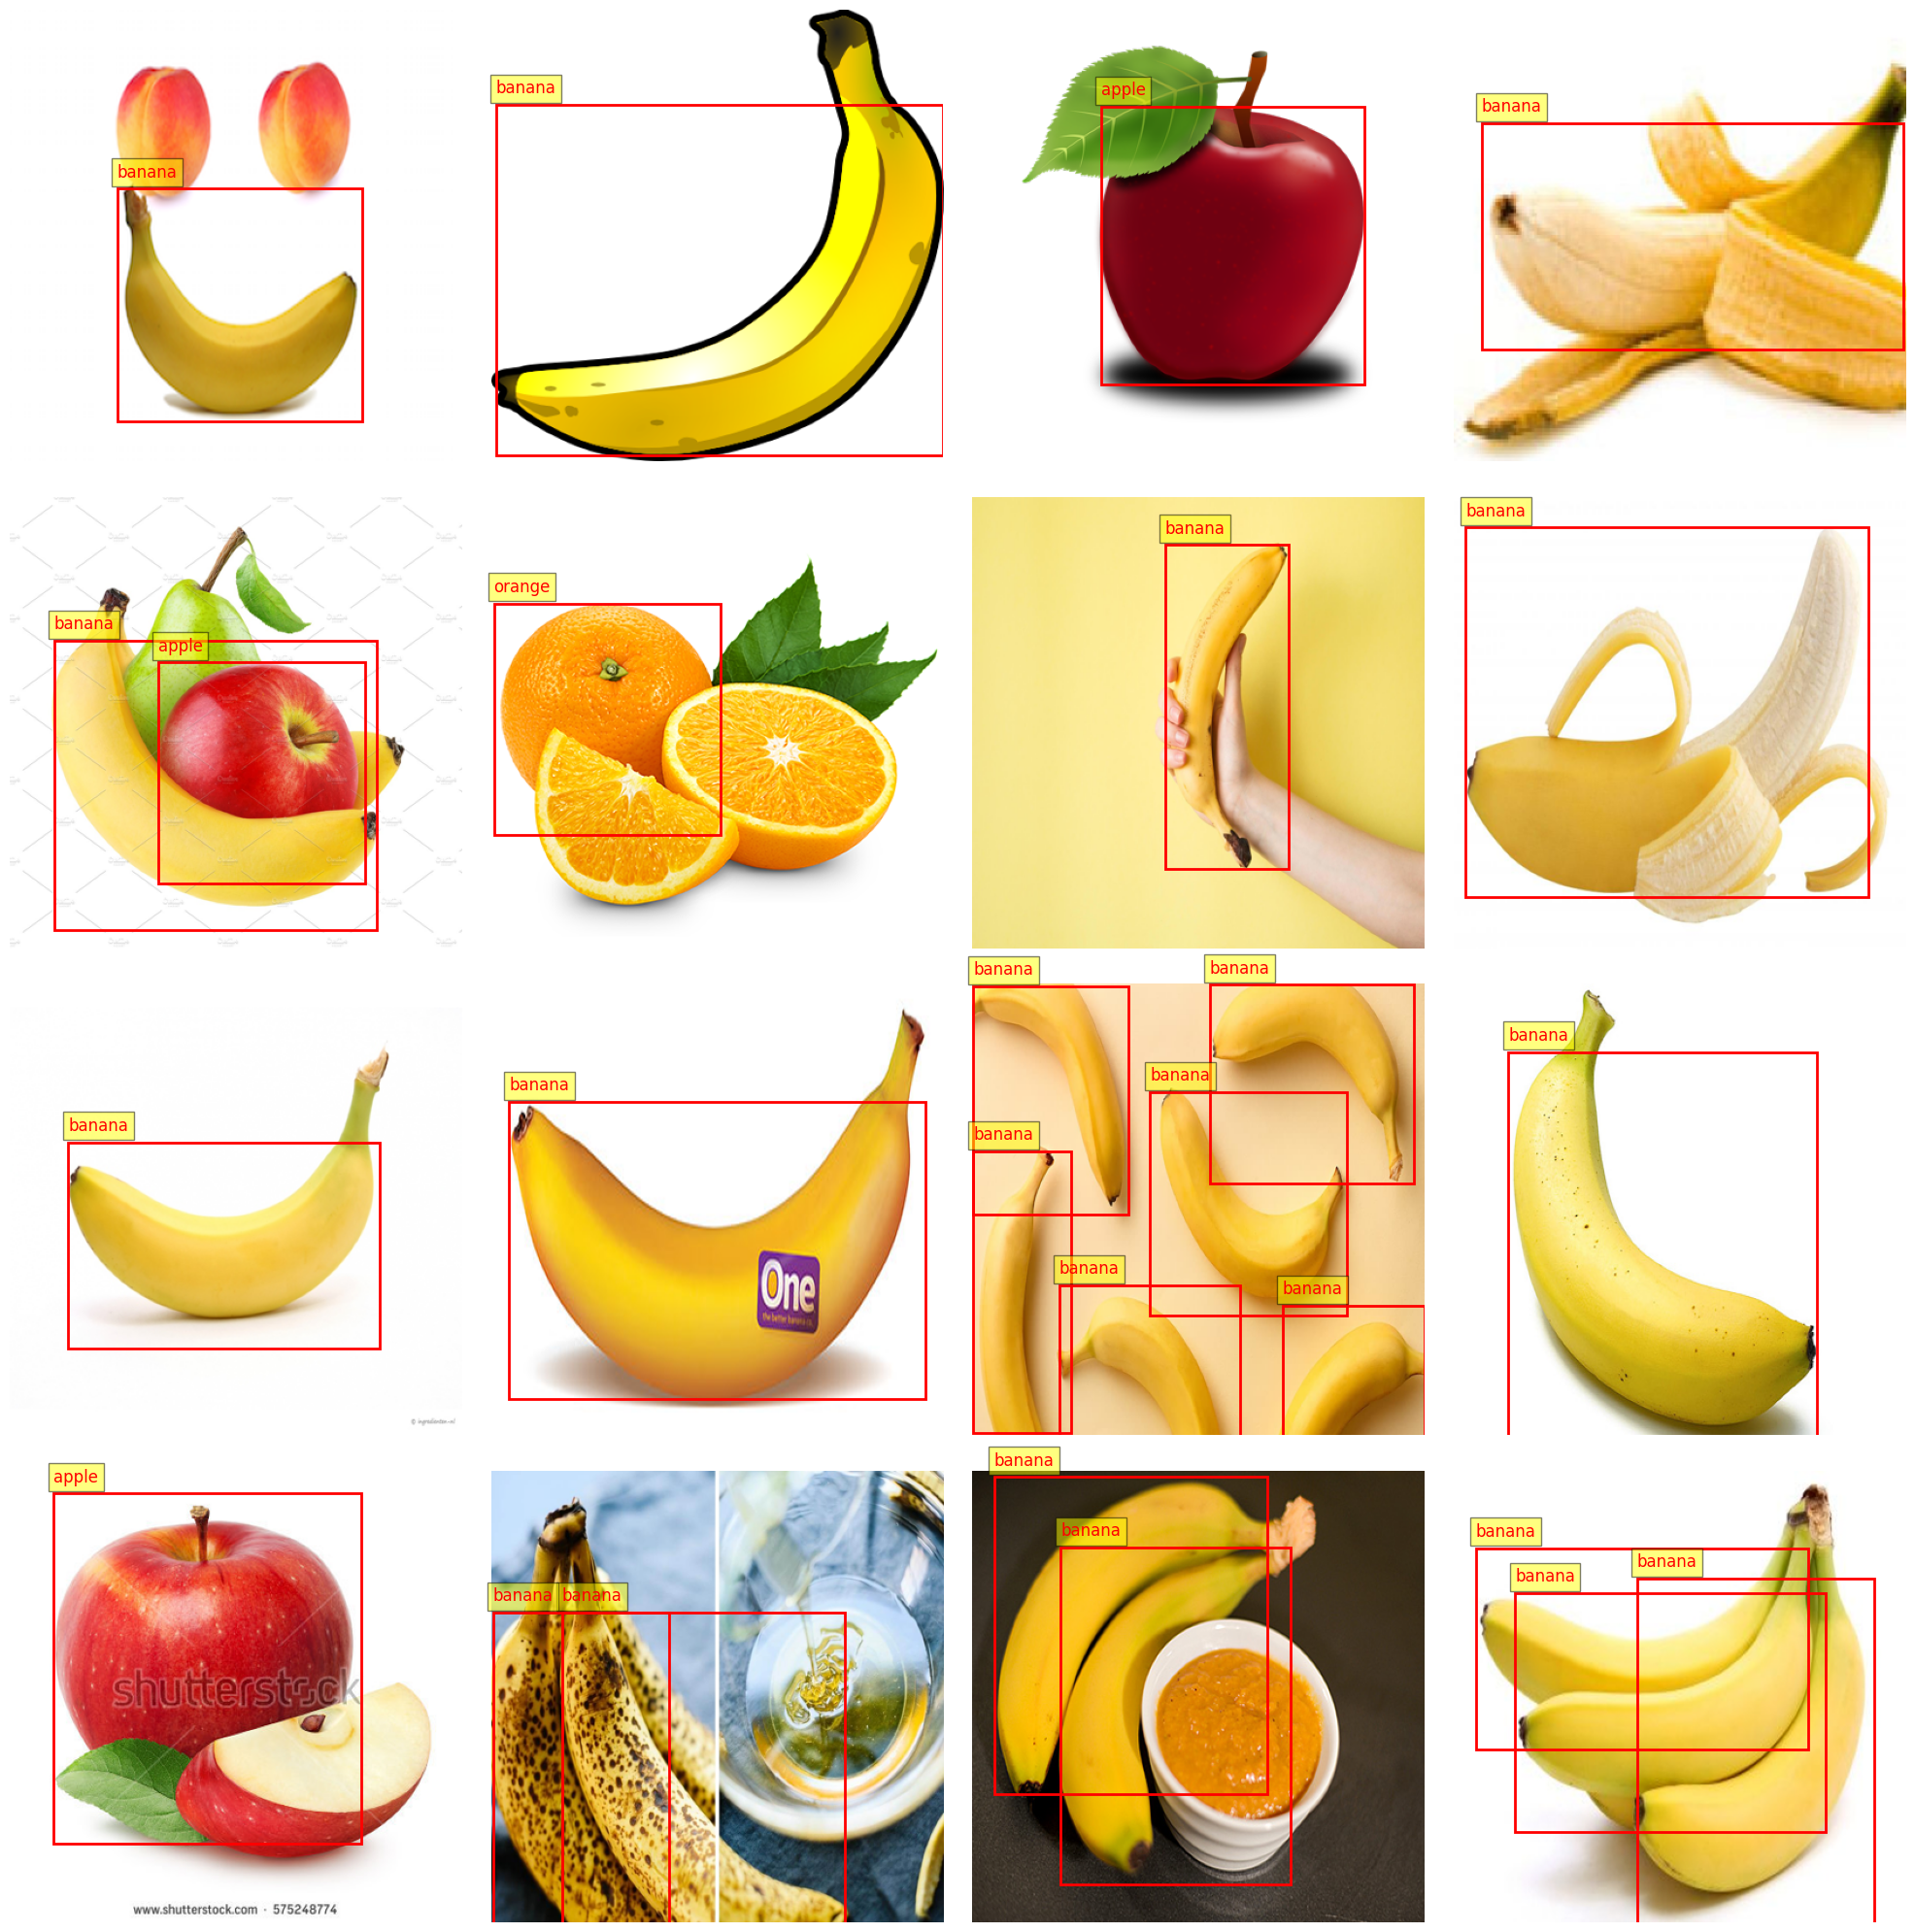

In [23]:
import os
import random
import xmltodict
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def convert_xml_to_dict(xml_file):
    with open(xml_file) as file:
        xml_content = file.read()
    return xmltodict.parse(xml_content)

def get_annotations(xml_dict):
    annotations = xml_dict['annotation']
    objects = annotations['object']
    if type(objects) != list:
        objects = [objects]
    bboxes = []
    for obj in objects:
        bbox = obj['bndbox']
        bboxes.append({
            'class': obj['name'],
            'xmin': int(bbox['xmin']),
            'ymin': int(bbox['ymin']),
            'xmax': int(bbox['xmax']),
            'ymax': int(bbox['ymax'])
        })
    return bboxes

def visualize_image(ax, image_path, bboxes, resize_to=(400, 400)):
    image = Image.open(image_path)
    original_size = image.size
    image = image.resize(resize_to)
    ax.imshow(image)

    # Scale bounding boxes according to the resize
    x_scale = resize_to[0] / original_size[0]
    y_scale = resize_to[1] / original_size[1]

    for bbox in bboxes:
        rect = patches.Rectangle(
            (bbox['xmin'] * x_scale, bbox['ymin'] * y_scale),
            (bbox['xmax'] - bbox['xmin']) * x_scale,
            (bbox['ymax'] - bbox['ymin']) * y_scale,
            linewidth=2,
            edgecolor='r',
            facecolor='none'
        )
        ax.add_patch(rect)
        ax.text(
            bbox['xmin'] * x_scale,
            (bbox['ymin'] * y_scale) - 10,
            bbox['class'],
            color='red',
            fontsize=12,
            bbox=dict(facecolor='yellow', alpha=0.5)
        )
    ax.axis('off')

def visualize_random_images_grid(folder_path, grid_size=(4, 4), resize_to=(400, 400)):
    num_images = grid_size[0] * grid_size[1]
    xml_files = [f for f in os.listdir(folder_path) if f.endswith('.xml')]
    random_files = random.sample(xml_files, num_images)

    fig, axs = plt.subplots(grid_size[0], grid_size[1], figsize=(20, 20))
    axs = axs.flatten()

    for i, xml_file in enumerate(random_files):
        xml_path = os.path.join(folder_path, xml_file)
        xml_dict = convert_xml_to_dict(xml_path)
        annotations = get_annotations(xml_dict)

        image_file = xml_dict['annotation']['filename']
        image_path = os.path.join(folder_path, image_file)

        visualize_image(axs[i], image_path, annotations, resize_to)

    plt.tight_layout()
    plt.show()

# Replace '/path/to/your/folder' with the path to your folder containing XML and image files
folder_path = '/content/train_zip/train'

visualize_random_images_grid(folder_path, grid_size=(4, 4))


Some of the fruit is bad labeled, but we are going to use it just to see the results over the different photos and see some interesting experiments.

## Train the model
We are going to train a model using yolo format and the other with the use of a coco format. Let's see what happening, let's make some changes and let's track the results.

In [26]:
!pip install yolov5 wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.4/953.4 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 40.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 782.8/782.8 kB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.6/112.6 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.1/296.1 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.9

In [36]:
# Install yolov5
# Clonar el repositorio de YOLOv5
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5
!pip install -r requirements.txt
%cd /content/

Cloning into 'yolov5'...
remote: Enumerating objects: 16646, done.
remote: Counting objects: 100% (187/187), done.
remote: Compressing objects: 100% (131/131), done.
remote: Total 16646 (delta 80), reused 115 (delta 56), pack-reused 16459
Receiving objects: 100% (16646/16646), 15.34 MiB | 21.20 MiB/s, done.
Resolving deltas: 100% (11379/11379), done.
/content/yolov5/yolov5
/content


A train.yml has been created in order to point to the folders where the model has to be trained. We are going to test using 10 epochs. One of the main purposes of this colab is to learn how to use wandadb to visualize all the results we are having using our models. The tracking is a really important thing for image processing.


In [49]:
import wandb

# Inicializar wandb
wandb.login()

# Path to the dataset and configuration file
dataset_path = '/content/train_data/train_output'
data_yaml_path = '/content/train.yml'

# Configuration for YOLOv5 training
config = {
    'epochs': 10,
    'batch_size': 16,
    'img_size': 640,
    'data': data_yaml_path,
    'cfg': 'yolov5s.yaml',
    'weights': 'yolov5s.pt',
    'name': 'yolov5_fruit_detector',
    'project': 'YOLOv5_Fruit_Detection'
}

# Inicializar wandb run
wandb.init(project=config['project'], name=config['name'])

# Train YOLOv5 model
!python /content/yolov5/train.py --img {config['img_size']} --batch {config['batch_size']} --epochs {config['epochs']} --data {config['data']} --cfg {config['cfg']} --weights {config['weights']} --project {config['project']} --name {config['name']}

# Log training results
wandb.log({"training_results": "Training completed"})
wandb.finish()




wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-06-19 15:33:29.489551: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-19 15:33:29.489616: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-19 15:33:29.491264: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: Currently logged in as: lucasrebra97 (lucasrebra). Use `wandb login --relogin` to force relogin
train: weights=yolov5s.pt, cfg=yolov5s.yaml, data=/content/train.yml, hyp=yolov5/data/hyps/hyp.scratc

training_results,Training completed


# Registrar varios experimentos y compararlos en WanDB
El proceso que se debe seguir a la hora de registrar los datos es el siguiente:
1. Realizar múltiples experimentos y guardar convenientemente en wandb.
2. Acceder al proyecto de wandb y a las estadísticas que nos da wandb con las diferentes configuraciones que se han realizado. Estas configuraciones contando con sus hiperparámetros nos ayudarán a entender qué está funcionando adecuadamente, qué influye dentro de nuestros experimentos y qué podemos cambiar para mejorar los experimentos.
3. Planificar los nuevos experimentos, de forma que los resultados se deban mejorar pero con base teórica y con análisis crítico y no al azar.

## Código definitivo para entrenar el modelo

In [ ]:
import wandb

def train_yolov5(epochs, batch_size, img_size, learning_rate, weight_decay):
    # Configuración para YOLOv5 y wandb
    config = {
        'epochs': epochs,
        'batch_size': batch_size,
        'img_size': img_size,
        'learning_rate': learning_rate,
        'weight_decay': weight_decay,
        'data': 'data.yaml',
        'cfg': 'yolov5s.yaml',
        'weights': 'yolov5s.pt',
        'name': f'yolov5_fruit_{epochs}_{batch_size}_{img_size}_{learning_rate}_{weight_decay}',
        'project': 'YOLOv5_Fruit_Detection'
    }

    # Inicializar wandb run
    wandb.init(project=config['project'], name=config['name'], config=config)

    # Ejecutar el entrenamiento de YOLOv5
    !python train.py --img {config['img_size']} --batch {config['batch_size']} --epochs {config['epochs']} --data {config['data']} --cfg {config['cfg']} --weights {config['weights']} --hyp hyp.scratch-low.yaml --project {config['project']} --name {config['name']}

    # Terminar wandb run
    wandb.finish()


# Código para poder correr varios experimentos

In [ ]:
# Definir diferentes combinaciones de hiperparámetros
experiments = [
    {'epochs': 10, 'batch_size': 16, 'img_size': 640, 'learning_rate': 0.01, 'weight_decay': 0.0005},
    {'epochs': 20, 'batch_size': 16, 'img_size': 640, 'learning_rate': 0.01, 'weight_decay': 0.0005},
    {'epochs': 10, 'batch_size': 32, 'img_size': 640, 'learning_rate': 0.001, 'weight_decay': 0.0005},
    {'epochs': 10, 'batch_size': 16, 'img_size': 640, 'learning_rate': 0.01, 'weight_decay': 0.005},
    # Agrega más combinaciones según sea necesario
]

# Ejecutar los experimentos
for exp in experiments:
    train_yolov5(**exp)
